# Parker population AIF

> Population AIF

References:
1. McGrath et al, Magnetic Resonance in Medicine 61:1173–1184 (2009)
1. Parker et al, Magnetic Resonance in Medicine 56:993–1000 (2006)

In [1]:
#| default_exp parker

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| hide


In [4]:
#| export
from typing import Union
import numpy as np
from math import sqrt, pi
import scipy.optimize as optimize


def parker(x: tuple, # Parker parameters (A1, A2, T1, T2, sigma1, sigma2, alpha, beta, s, tau)
           N: int, # Length of signal
           t: np.ndarray # Timeline in seconds (length `N`)
          ) -> np.ndarray: # Signal at timepoints `t`
    """Calculate a AIF signal, given the supplied parameters."""
    # print('parker: x {} '.format(x.shape))
    A1, A2, T1, T2, sigma1, sigma2, alpha, beta, s, tau = x
    # print(A1,A2,T1,T2,sigma1,sigma2,alpha,beta,s,tau)

    term = np.zeros((3, N))
    term[0] = A1 / sigma1 / sqrt(2 * pi) * np.exp(-((t - T1) ** 2) / 2 / (sigma1 ** 2))
    term[1] = A2 / sigma2 / sqrt(2 * pi) * np.exp(-((t - T2) ** 2) / 2 / (sigma2 ** 2))
    term[2] = alpha * np.exp(-beta * t) / (1 + np.exp(-s * (t - tau)))

    # aif = np.sum(term, axis=0) * scaling
    aif = np.sum(term, axis=0)
    # return aif, term[0], term[1], alpha*np.exp(-beta*t), 1/(np.exp(-s*(t-tau)))
    return aif


def parker_cost_function(x: tuple, # Parker parameters  (A1, A2, T1, T2, sigma1, sigma2, alpha, beta, s, tau)
                         t: np.ndarray, # Timeline in seconds
                         y: np.ndarray # Measured data
                        ) -> np.ndarray: # Difference
    """Calculate difference between parker function and given data `y`."""
    return parker(x, y.shape[0], t) - y


def estimate_parkers_model(measured: np.ndarray, # Measured data
                           timeline: np.ndarray, # Timeline in seconds
                           return_result: bool = False, # When True, return OptimizeResult, otherwise return fitted parameters
                           verbose: bool = True # Whether estimated parameters will be printed
                          ) -> Union[optimize.OptimizeResult, np.ndarray]:
    """Estimate best Parker parameters for `measured` data."""
    # timeline in minutes
    norm_factor = max(measured)
    y = measured / norm_factor

    A1 = 0.809
    A2 = 0.33
    T1 = 0.17046
    T2 = 0.365
    sigma1 = 0.0563
    sigma2 = 0.132
    alpha = 1.050
    beta = 0.1685
    s = 38.078
    tau = 0.483

    x0 = np.array((A1, A2, T1, T2, sigma1, sigma2, alpha, beta, s, tau))
    lb = np.array((0, 0, 0.1, 0.2, 1e-9, 1e-9, 1e-3, 0, 0, 0))
    ub = np.array((5, 5, 2, 2, 0.5, 0.7, 5.0, 1.17, 50, 1.5))
    xs = np.array((1, 1, 1, 1, 20, 10, 1, 1, 0.05, 1))
    result = optimize.least_squares(parker_cost_function, x0, bounds=(lb, ub), x_scale=xs,
                                    args=(timeline, y), verbose=1, ftol=1e-3, xtol=1e-3, gtol=1e-3)
    if verbose:
        print('estimate_parkers_model: result.cost: {}'.format(result.cost))
        print('estimate_parkers_model: A1    : {:6.3f} {:6.3f}'.format(x0[0], result.x[0]))
        print('estimate_parkers_model: A2    : {:6.3f} {:6.3f}'.format(x0[1], result.x[1]))
        print('estimate_parkers_model: T1    : {:6.3f} {:6.3f}'.format(x0[2], result.x[2]))
        print('estimate_parkers_model: T2    : {:6.3f} {:6.3f}'.format(x0[3], result.x[3]))
        print('estimate_parkers_model: sigma1: {:6.3f} {:6.3f}'.format(x0[4], result.x[4]))
        print('estimate_parkers_model: sigma2: {:6.3f} {:6.3f}'.format(x0[5], result.x[5]))
        print('estimate_parkers_model: alpha : {:6.3f} {:6.3f}'.format(x0[6], result.x[6]))
        print('estimate_parkers_model: beta  : {:6.3f} {:6.3f}'.format(x0[7], result.x[7]))
        print('estimate_parkers_model: s     : {:6.3f} {:6.3f}'.format(x0[8], result.x[8]))
        print('estimate_parkers_model: tau   : {:6.3f} {:6.3f}'.format(x0[9], result.x[9]))
    if return_result:
        return result
    else:
        return result.x

In [5]:
#| hide
import nbdev; nbdev.nbdev_export()

In [6]:
#| hide
import matplotlib.pyplot as plt

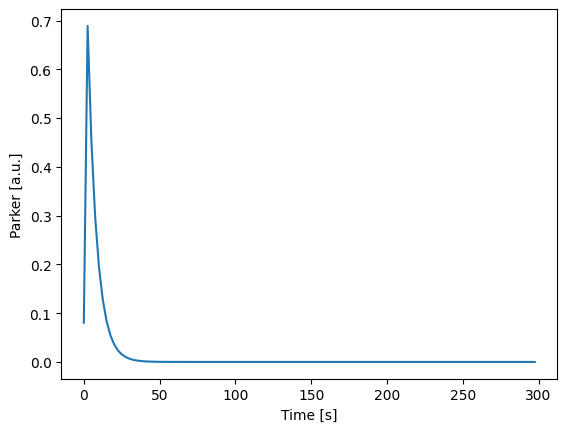

In [7]:
x = (0.809, 0.33, 0.17046, 0.365, 0.0563, 0.132, 1.050, 0.1685, 38.078, 0.483)
timeline = np.arange(0., 300., 2.5)
p = parker(x, len(timeline), timeline)

fig, ax = plt.subplots()
ax.plot(timeline, p)
ax.set_ylabel('Parker [a.u.]')
ax.set_xlabel('Time [s]')
plt.show()